# Young Thug Project - LIGN 6

In this project my goal has been to compare the sound of Young Thug to other popular artists in the industry to see who compares to his unique style. My expectation is that other modern artists in the hip hop genre will be the most similar but I have also included more seasoned rappers as well as artists from pop and rock/alternative genres. 

I have featured 17 artists, I collected and cleaned 100 songs total; 20 songs from Young Thug and 5 for every other artist. The artists analyzed are:
* Young Thug
* Gunna
* Lil Baby
* J. Cole
* Kendrick Lamar
* Drake
* Tyler, The Creator
* Justin Bieber
* Billie Ellish
* Taylor Swift
* Megan Thee Stallion
* Adele
* Olivia Rodrigo
* Adriana Grande
* The Offspring
* Paramore
* Nirvana

### Data Collection
I have collected all of the data using the Spotify API. The song list is hosted on Spotify and can be reached by following the link [here](https://open.spotify.com/playlist/2GsE0FXR8SZCYvRjjNn6t0?si=7c8ec7305fc34707). I have also used the Spotipy package which is a basic python wrapper for the Spotify API. The two main API calls for this project are get_audio_analysis and get_audio_features



In [15]:
#base
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [16]:
credentials = SpotifyClientCredentials(client_id=os.environ['SPOTIFY_CLIENT_ID'],
                                       client_secret= os.environ['SPOTIFY_CLIENT_SECRET'])
sp = spotipy.Spotify(auth_manager=credentials, requests_timeout=500)

In [17]:
target_artist_list = ['Young Thug', 'Gunna', 'Lil Baby', 'J. Cole', 'Kendrick Lamar', 'Drake', 
                      'Tyler, The Creator', 'Justin Bieber', 'Billie Ellish', 'Taylor Swift',
                      'Megan Thee Stallion', 'Adele', 'Olivia Rodrigo', 'Adriana Grande',
                      'The Offspring', 'Paramore', 'Nirvana']
playlist_url = 'https://open.spotify.com/playlist/2GsE0FXR8SZCYvRjjNn6t0?si=7c8ec7305fc34707'
playlist = sp.playlist_items(playlist_url)

### Reading Data
In terms of data organization, I have split the data into 3 main parts depending on data granulariy

#### General
The general table is the least granular of the 3 at the song level. As such there are only about 100 rows. Since some of the songs have more than one artist on them, I have given each artist on the track their own row. This aspect is a little problematic since the most similar artists will be those who featured on the same track. I have made sure to prevent this issue by also accounting for song name in the analysis.

#### Section
The section table has more samples than the general tab with about 10 rows per song. This table along with the Segment table were the most difficult with multiple artists on one track. I was able to counter this by listening to the songs and taking account of when each artists would come on. The results of this are in the `song_urls.txt` file. There were a few categorical variables here including key, mode, and time signature that I vectorized using One Hot Encoding.

#### Segment
The segment table had the smallest granularity with about 1000 samples per song. This was the most important table for me since it also contained timbre. According to music theory, timbre is a good choice for distinguishing between how the music sounds. The Spotify API version is split into an array of 12 values. While the documentation does not reveal much about what these values mean individually, they were pivotal in the relational analysis

In [18]:
#EXTRACTING DATA FROM API CALLS

gen_arr = []
sect_arr = []
segm_arr = []

for sng in playlist['items']:
    #dont go over rate limit!
    #time.sleep(0.5)
    base_dict = {}
    sng = sng['track']
    #get meta information: track name, artist/s
    base_dict['artists'] = [artist_dict['name'] for artist_dict in sng['artists']]
    base_dict['name'] = sng['name']
    #get each track id to extract features
    base_dict['id'] = sng['id']
    #extract track information
    sng_feats = sp.audio_features(base_dict['id'])[0]
    sng_analy = sp.audio_analysis(base_dict['id'])
    #add extracted info appropriately 
    sng_feats.update(base_dict)
    gen_arr.append(sng_feats)
    
    sng['sections'] = sng_analy['sections']
    [sect_dict.update(base_dict) for sect_dict in sng_analy['sections']]
    sect_arr.append(sng_analy['sections'])
    
    sng['segments'] = sng_analy['segments']
    [segm_dict.update(base_dict) for segm_dict in sng_analy['segments']]
    segm_arr.append(sng_analy['segments'])
    
    

In [122]:
#HELPER FUNCTIONS

#splits the segment and sections tables into their own artists
def fix_artists(row, time_df):
    song_id = row.id
    song_time_arr = time_df[time_df['id'] == song_id].values
    start = row.start
    if len(song_time_arr) > 0:
        for correction in song_time_arr:
            if start >= correction[1] and start < correction[2]:
                row.artists = correction[3]
        
    else:
        row.artists = row.artists[0]
    return row

#gets the 5 most similar artists to the row using jaccard similarity on the other rows 
def get_nearest_jacc(row, df):
    #first get artist and song information
    artist = row.artists
    sng_id = row.id
    #get samples from other artists that are not the same song, those would be too similar
    non_sng_df = df[df['id'] != sng_id ]
    non_sng_df = non_sng_df[non_sng_df['artists'] != artist]
    #get jaccard and get 5 artists whose elements have the highest similarity
    target_df = non_sng_df.drop(['id','artists'],axis=1)
    target_idxs = target_df.multiply(row).sum(axis=1).divide(len(target_df.columns)).sort_values(ascending=False).index[0:5]
    return df.loc[target_idxs,'artists'].values

#gets the 5 most similar artists to the row using squared distance on the other rows 
def get_nearest(row, df):
    #first get artist and song information
    artist = row.artists
    sng_id = row.id
    is_timbre = True
    try:
        timb_id = row.timbre_idx
    except AttributeError:
        is_timbre = False
        
    #make sure we are using a Young Thug song
    if artist != "Young Thug":
        return np.nan
    #get samples from other artists that are not the same song, those would be too similar
    non_sng_df = df[df['id'] != sng_id ]
    non_sng_df = non_sng_df[non_sng_df['artists'] != artist]
    if is_timbre:
        non_sng_df = non_sng_df[non_sng_df['timbre_idx'] == timb_id]
    #get distance between other elements and get 5 artists whose elements have the smallest distance
    target_df = non_sng_df.drop(['id','artists'],axis=1)
    target_idxs = target_df.subtract(row).pow(2).sum(axis=1).sort_values().index[0:5]
    return df.loc[target_idxs, 'artists'].values

In [20]:
#READING DATA AND FIXING FEATURED ARTISTS

#turn features, sections, and segments to dataframes
gen_df_raw = pd.DataFrame(gen_arr)
sect_df_raw = pd.DataFrame(np.concatenate(sect_arr).tolist())
segm_df_raw = pd.DataFrame(np.concatenate(segm_arr).tolist())
#fix featuring artists
gen_df = gen_df_raw.explode('artists').reset_index(drop=True)
artist_time_df = pd.read_csv('song_urls.txt')
sect_df = sect_df_raw.apply(fix_artists, axis=1, args=(artist_time_df,))
segm_df = segm_df_raw.apply(fix_artists, axis=1, args=(artist_time_df,))

In [21]:
#ENCODING PITCH AND TIMBRE ARRAYS FROM SEGMENT

#split timbre and pitch arrays into their own columns
pitches = ['C', 'C-sharp', 'D', 'D-sharp', 'E', 'F', 'F-sharp', 'G', 'G-sharp', 'A', 'B-flat', 'B']
pitches_col = segm_df.pitches
timbres = ["timbre_{}".format(x) for x in range(12)]
timbre_col = segm_df.timbre

for i in np.arange(12):
    timbre_nm = "timbre_{}".format(i)
    segm_df[pitches[i]] = pitches_col.apply(lambda x: x[i])
    segm_df[timbre_nm] = timbre_col.apply(lambda y: y[i])

In [22]:
#ONE HOT ENCODING PITCH, MODE, AND TIME SIGNATURE FROM CATEGORICAL VARIABLES FROM SECTION

#One hot encode key (aka pitch), mode, and time signature categorical variables
modes = ['minor', 'major']
hotter = OneHotEncoder(sparse=False)

#one hot encode
key_trans = hotter.fit_transform(sect_df[['key']])
mode_trans = hotter.fit_transform(sect_df[['mode']])
time_trans = hotter.fit_transform(sect_df[['time_signature']])
time_cats = ['time_sig_{}/4'.format(x) for x in hotter.categories_[0]]

#transform to dataframe and add to main df
pitches_hotted = pd.DataFrame(columns=pitches,data=key_trans)
modes_hotted = pd.DataFrame(columns=modes, data=mode_trans)
time_hotted = pd.DataFrame(columns=time_cats, data=time_trans)

sect_df = pd.concat([sect_df, pitches_hotted, modes_hotted, time_hotted], axis=1)

### Feature Selection

In terms of feature selection I wanted to use features that were not present in other tables to minimize colinearity between each of the tables.I also wanted to select features that would be the most effective combined. For each set of numerical features, I made sure to keep all numbers between 0 and 1 since some of the variables had different ranges. For each table I choose the following features and similarity function

* Segment - timbre - distance

For segment I only chose timbre due to the massive amount of samples which needed to be managed. This section took the longest to compute at about 15 minutes due to the large number of expensive distance calculations. I choose minimum distance as the similarity function since the values were scaled from 0 to 1.

* Section - key,mode,time_signature - Jaccard

For section I choose to analyze the traditional musicality since there were fewer samples but still contained a decent amount of granularity. This table is probably the least valuable since it focuses on the music more than the artist. I used Jaccard similarity for this table since each of the variables were categorical.

* General - danceability,energy,speechiness,acousticness,instrumentalness - distance

For the general table since the granularity was at the song level, I wanted to leverage features that were more hollistic. The features are given directly from Spotify themselves so there is not much information on how exactly each of these features is derrived. I also used squared distance for this since all of the features were numerical.

### Analysis
In the analysis portion I found the 5 most similar segments, sections, or songs for each row that were not the same artist or the same song. After getting the 5 most similar segments, I got the artists for each of the 5 segments and moved on to the next row. At the end, I was able to group the rows by artist and I tallied up the artists in the 5 most similar arrays. I used this method instead of an average distance or some other summary statistic because I wanted to keep the level of analysis small. This was especially important to me for timbre in the segment table since each sample was inherently different  and I felt that there were enough samples to get a decent generalization from it.

In [23]:
#DROPPING UNIMPORTANT COLUMNS IN SEGMENT

segm_nonfeat_cols = ['start', 'duration', 'confidence', 'pitches', 'timbre','name']
segm_clean_df = segm_df.drop(segm_nonfeat_cols, axis=1)

In [24]:
#RESCALING SEGMENT FEATURES TO MIN 0 AND MAX 1

normer = MinMaxScaler()
normed_segm = normer.fit_transform(segm_clean_df.drop(['id', 'artists'], axis=1))
segm_scaled_df = pd.DataFrame(columns=normer.feature_names_in_, data=normed_segm)
segm_scaled_df = pd.concat([segm_scaled_df, segm_clean_df[['id', 'artists']]],axis=1)


In [113]:
#FIND MOST SIMILAR IN SEGMENT USING SQUARED DISTANCE
#WARNING: THIS SECTION TAKES A WHILE TO RUN

normed_timbre = normer.fit_transform(segm_clean_df.loc[:,timbres])
timbre_scaled_df = pd.DataFrame(columns=normer.feature_names_in_, data=normed_timbre)
timbre_scaled_df = pd.concat([timbre_scaled_df, segm_clean_df[['id','artists']]], axis=1)

timbre_idxs = timbre_scaled_df.groupby('id').apply(lambda x: np.arange(x.iloc[:,0].count())).explode()
timbre_scaled_df['timbre_idx'] = timbre_idxs.values

most_sim_timbre = timbre_scaled_df.apply(get_nearest, args=(timbre_scaled_df,),axis=1)

In [114]:
segm_results = most_sim_timbre.dropna().explode().reset_index(drop=True).value_counts()

<AxesSubplot:title={'center':'Similarity to Young Thug (Section)'}>

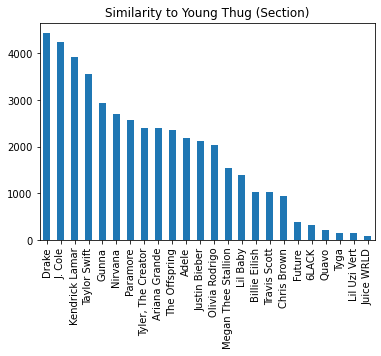

In [115]:
segm_results.plot(kind='bar', title='Similarity to Young Thug (Section)')

In [116]:
#DROPPING UNIMORTANT COLUMNS IN SECTION
sect_nonfeat_cols = ['start','duration','confidence','tempo_confidence','key', 'key_confidence',
                     'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence',
                     'name', 'loudness', 'tempo']
sect_clean_df = sect_df.drop(sect_nonfeat_cols, axis=1)

In [117]:
#FIND MOST SIMILAR IN SECTION USING JACCARD SIM

sect_results = sect_clean_df[sect_clean_df['artists']=='Young Thug'].apply(get_nearest_jacc, args=(sect_clean_df,),axis=1).explode().value_counts()
sect_results

Paramore               55
Travis Scott           43
Olivia Rodrigo         41
Tyler, The Creator     41
Adele                  37
Gunna                  37
J. Cole                37
Megan Thee Stallion    36
Nirvana                24
Justin Bieber          23
Kendrick Lamar         22
Drake                  20
The Offspring          19
Billie Eilish          18
Chris Brown            14
Lil Baby               14
Ariana Grande          11
Taylor Swift           10
6LACK                   9
Quavo                   2
Juice WRLD              1
Future                  1
dtype: int64

<AxesSubplot:title={'center':'Similarity to Young Thug (Section)'}>

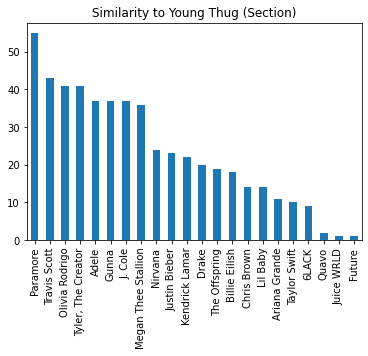

In [118]:
sect_results.plot(kind='bar', title='Similarity to Young Thug (Section)')

In [119]:
#DROPPING UNIMPORTANT COLUMNS IN GENERAL

gen_nonfeat_cols = ['key', 'mode','type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 
                    'time_signature', 'name']
gen_clean_df = gen_df.drop(gen_nonfeat_cols, axis=1)

In [120]:
#RESCALING GENERAL FEATURES TO MIN 0 AND MAX 1

normer = MinMaxScaler()
normed_gen = normer.fit_transform(gen_clean_df.drop(['id', 'artists'], axis=1))
gen_scaled_df = pd.DataFrame(columns=normer.feature_names_in_, data=normed_gen)
gen_scaled_df = pd.concat([gen_scaled_df, gen_clean_df[['id', 'artists']]],axis=1)

In [123]:
#FIND MOST SIMILAR IN GENERAL USING SQUARED DISTANCE
gen_target_df = gen_scaled_df.loc[:,['artists','id','danceability', 'energy', 'speechiness','acousticness', 'instrumentalness']]
gen_results_df = pd.concat([gen_scaled_df, gen_target_df.apply(get_nearest, args=(gen_scaled_df,),axis=1)],axis=1)

gen_results = gen_results_df.explode(0).groupby('artists').apply(lambda x: x[0].value_counts())['Young Thug']
gen_results

Gunna                  24
Drake                  16
Lil Baby                8
Megan Thee Stallion     7
J. Cole                 6
Ariana Grande           6
Travis Scott            5
Kendrick Lamar          5
Future                  4
Chris Brown             4
Taylor Swift            4
Juice WRLD              3
Justin Bieber           3
Lil Uzi Vert            2
Young Stoner Life       2
Nirvana                 2
Adele                   1
Billie Eilish           1
Quavo                   1
6LACK                   1
Name: 0, dtype: int64

In [ ]:
gen_results.plot(kind='bar', title='Similarity to Young Thug (General)')

### Results
Overall I was excited to see different results for each of the tables I looked at. 

Starting with the results from the General table, these were the results I would expect when asking someone who Young Thug sounds most like. Young Thug works closely with both Gunna and Drake. Lil Baby is also expected here as he is also considered another 'mumble rapper'. One surprise is that Ariana Grande was able to outrank Kendrick Lamar even if it was just by a single mention.

The results from section were the most surprising for me. The biggest surprise is that the top 2 artists are alternative and pop artists respectively (Travis Scott isn't officially being analyzed but he did feature in several songs). Furthurmore, another surpirse is seeing Adele tied with Gunna in mentions. These results reveal that there is more to the sound of music than the chords and time signatures which is where timbre comes in.

The results from segment were the most anticipated out of the 3 tables. One big surprise off the bat is seeing J. Cole beating out both Drake and Gunna for the top spot. These results make sense based on the songs I sampled from each artist. For example, for J. Cole I sampled songs where he was more lyrically involved as well as Young Thug. Where I suspect J. Cole took the cake was with Young Thug's sample of **Feel It** and J. Cole's **Foldin Clothes**. These two songs are both very soft and melodic songs on a roster of songs that tend to be more energetic and intense. Another piece of analysis I noticed was that Billie Elish tended to be at the bottom of most of these comparisons. While it seems that J. Cole, Drake, and Gunna are the most similar to Young Thug, Billie Elish seems to be the most disimilar.
